In [1]:
using JLD
using HDF5
using Dates
using PyCall
using Random
using Plots
using PyPlot
using Statistics
using BenchmarkTools
using DataFrames, IndexedTables
using Flux: onehot, onehotbatch, softmax, sigmoid
using BSON: @load, @save

system = "cartpole"
include("$system/problem.jl")
include("$system/strategy_utils.jl")
include("$system/utils.jl")
include("$system/models.jl")
include("fileIO.jl");

In [2]:
ENV["CUDA_VISIBLE_DEVICES"] = "0"

pushfirst!(PyVector(pyimport("sys")."path"), @__DIR__) #need this to be able to source from pytorch.models
torch = pyimport("torch")
torch.cuda.empty_cache()
torchvision = pyimport("torchvision")
np = pyimport("numpy")
sns = pyimport("seaborn")

FFNet = pyimport("pytorch.models")."FFNet" #import custom nn class

PyObject <class 'pytorch.models.FFNet'>

In [3]:
prob_files = [string("$system/data/testdata",ii,".jld") for ii=1:20] #filenames, choose 1-16 for training
prob_dicts = [load(f) for f in prob_files]

# Set problem specific features
prob_features = ["X0", "Xg", "dist_to_goal", "delta2_0", "delta3_0", "delta2_g", "delta3_g"]

N = 11
n_obs = 0

# Calculate length of feature vector
feature_size = 0
if "X0" in prob_features feature_size += 4 end
if "Xg" in prob_features feature_size += 4 end
if "dist_to_goal" in prob_features feature_size += 1 end
if "delta2_0" in prob_features feature_size += 1 end
if "delta3_0" in prob_features feature_size += 1 end
if "delta2_g" in prob_features feature_size += 1 end
if "delta3_g" in prob_features feature_size += 1 end
feature_size = Int(feature_size)

# Optimization problem handle
prob_handle = getCartpoleProb

depth = 3
neurons = 32

training_percentage = 0.9
training_batch_length = Int(round(training_percentage*length(prob_dicts)));

# Identify possible strategies

A dictionary is generated where the keys are indices of integer constraints that would be in violation and the values are (strategy ID, value of first integer assignment corresponding to this strategy).

In [4]:
strategy_dict = Dict{Array{Int64,1}, Array{Int64,1}}()
training_labels = Dict{Array{Float64,1}, Array{Int64,1}}()

N_strategies = 0
for dir_idx in 1:training_batch_length
  for prob_idx in 1:length(prob_dicts[dir_idx]["Y"])
    y_true = vectorizeIntegerData(prob_dicts[dir_idx]["Y"][prob_idx])

    if !haskey(strategy_dict,y_true)
        # Strategy unseen
        N_strategies += 1
        strategy_dict[y_true] = [N_strategies; y_true]
    end

    prob_query = getProblemData(prob_dicts[dir_idx],prob_idx)
    features = construct_prob_features(fill(NaN,1), prob_query["prob_data"], prob_features)

    training_labels[features] = strategy_dict[y_true]
  end
end

N_strategies

581

In [5]:
X = zeros(Float64, feature_size, length(keys(training_labels)))
Y = zeros(Int64, 4*(N-1)+1, length(keys(training_labels)))

for (key_ct,v) in enumerate(training_labels)
    X[:,key_ct] = v[1]
    Y[:,key_ct] = v[2]
end

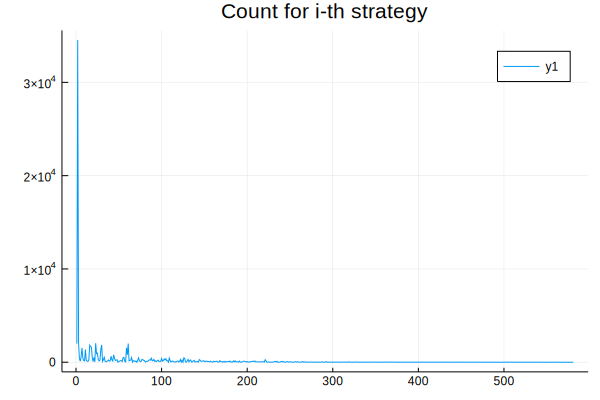

In [6]:
frequencies = zeros(Int64,N_strategies)
for ii in 1:N_strategies
    frequencies[ii] = sum(ii .== Y[1,:])
end
Plots.plot(1:N_strategies, frequencies, title="Count for i-th strategy")

In [ ]:
fn_model = string("models/mlopt_model_","$(system)_",Dates.format(DateTime(Dates.now()), "yyyymmdd_HHMM"), "_$(depth)-layers_$(neurons)-neurons.jld")

save(fn_model, "system", system, "N_strategies", N_strategies, "feature_size", feature_size,
    "X", X, "Y", Y, "strategy_dict", strategy_dict)

# Train model from terminal
Run `python train_classifier.py ../model/{fn_model}.jld` from the `pytorch` directory
This step will generate a `{fn_model}.pt` parameter file that will get loaded and used for evaluation in the next section

In [4]:
fn_model = "models/mlopt_model_cartpole_20200326_1757_3-layers_32-neurons.jld"
fn_dict = load(fn_model)
feature_size = fn_dict["feature_size"]
N_strategies = fn_dict["N_strategies"]
strategy_dict = fn_dict["strategy_dict"];

# Evaluate saved model

In [8]:
classifier_fn = replace(fn_model, ".jld"=>"_classifier.pt")
classifier_model = get_ff_classifier(feature_size, N_strategies; depth=depth,neurons=neurons)
classifier_model.load_state_dict(torch.load(classifier_fn))
n_evals = 10;

In [9]:
function solve_with_classifier(prob, prob_dicts, dir_idx, prob_idx, n_evals)    
    # Construct problem object
    y_binary = all_variables(prob)[is_binary.(all_variables(prob))]
    unset_binary.(y_binary) #relax so we solve LPs

    prob_query = getProblemData(prob_dicts[dir_idx],prob_idx)
    features = construct_prob_features(fill(NaN,1), prob_query["prob_data"], prob_features)
    input = torch.from_numpy(reshape(features,1,feature_size)).float()

    # Grab the n_evals-best strategies for this problem
    solve_time = @elapsed begin
        scores = classifier_model(input).cpu().detach().numpy()[:];
    end
    ind_max = partialsortperm(scores, 1:n_evals, rev=true)

    # Get integer assignments for each obstacle
    y_strats = [Array{Int64,1}() for _ in 1:n_evals]
    # Search through strategy dictionary to find the strategy
    # corresponding to classifier output
    for (k,v) in enumerate(strategy_dict)
        for (ii,ind) in enumerate(ind_max)
            # First element of value will be index
            if ind == v[2][1]
                # Grab binary values for this strategy
                y_strats[ii] = v[2][2:end]
            end
        end
    end

    for (ii_eval,ind) in enumerate(ind_max)
        # y_guess = zeros(Int,length(y_binary))
        y_guess = y_strats[ii_eval]
        fix.(y_binary,round.(y_guess), force=true)

        original_stdout = stdout
        (read_pipe, write_pipe) = redirect_stdout()
        optimize!(prob)
        redirect_stdout(original_stdout)
        close(write_pipe)
        solve_time += MOI.get(prob, MOI.SolveTime())

        if termination_status(prob) == MOI.OPTIMAL
            return true, objective_value(prob), solve_time, ii_eval
        end
        unfix.(y_binary)
    end
    return false, Inf, Inf, n_evals
end

solve_with_classifier (generic function with 1 method)

In [10]:
costs_classifier = Float64[]
costs_ratios_classifier = Float64[]
solve_times_classifier = Float64[]
num_solves_classifier = Int[]

costs_IP = Float64[]
solve_times_IP = Float64[]
num_solves_IP = Int[]

num_classifier_successes = 0
total_runs = 0

for dir_idx in training_batch_length+1:length(prob_dicts)
    for prob_idx in 1:length(prob_dicts[dir_idx]["Y"])
        total_runs += 1
        prob_idx_success = false
        
        # Construct problem object
        prob = prob_handle(prob_dicts[dir_idx], prob_idx)[1]
        prob_success, cost, solve_time, n_attempts = solve_with_classifier(prob, prob_dicts, dir_idx, prob_idx, n_evals)
        if prob_success
            num_classifier_successes += 1
            push!(costs_classifier, cost)
            push!(solve_times_classifier, solve_time)
            push!(num_solves_classifier, n_attempts)

            true_cost = prob_dicts[dir_idx]["J"][prob_idx]
            push!(costs_IP, true_cost)
            push!(num_solves_IP, prob_dicts[dir_idx]["node_count"][prob_idx])
            push!(solve_times_IP, prob_dicts[dir_idx]["solve_time"][prob_idx])
            push!(costs_ratios_classifier, cost / true_cost)
        end
    end
    @warn "Done with $dir_idx"
end

mip_percentage = 100.
classifier_percentage = 100 *num_classifier_successes / total_runs

┌ Warning: Done with 19
└ @ Main In[10]:34
┌ Warning: Done with 20
└ @ Main In[10]:34


99.88

# Evaluate saved regression model

In [11]:
regressor_fn = replace(fn_model, ".jld"=>"_regressor.pt")
regressor_model = get_ff_regressor(feature_size, 4*(N-1); depth=depth,neurons=neurons)
regressor_model.load_state_dict(torch.load(regressor_fn));

In [12]:
function solve_with_regressor(prob, prob_dicts, dir_idx, prob_idx)
    # Construct problem object
    y_binary = all_variables(prob)[is_binary.(all_variables(prob))]
    unset_binary.(y_binary) #relax so we solve LPs

    prob_query = getProblemData(prob_dicts[dir_idx],prob_idx)
    features = construct_prob_features(fill(NaN,1), prob_query["prob_data"], prob_features)
    input = torch.from_numpy(reshape(features,1,feature_size)).float()

    # Grab the n_evals-best strategies for this problem
    solve_time = @elapsed begin
        y_guess = regressor_model(input).cpu().detach().numpy()[:]
    end
    y_guess = Int.(round.(sigmoid.(y_guess)))
    
    fix.(y_binary,round.(y_guess), force=true)

    original_stdout = stdout
    (read_pipe, write_pipe) = redirect_stdout()
    optimize!(prob)
    redirect_stdout(original_stdout)
    close(write_pipe)
    solve_time += MOI.get(prob, MOI.SolveTime())

    if termination_status(prob) == MOI.OPTIMAL
        return true, objective_value(prob), solve_time
    else
        return false, Inf, solve_time
    end
end

solve_with_regressor (generic function with 1 method)

In [13]:
costs_regressor = Float64[]
costs_ratios_regressor = Float64[]
solve_times_regressor = Float64[]
num_solves_regressor = Int[]

num_regressor_successes = 0
total_runs = 0

for dir_idx in training_batch_length+1:length(prob_dicts)
    for prob_idx in 1:length(prob_dicts[dir_idx]["Y"])
        total_runs += 1

        prob = prob_handle(prob_dicts[dir_idx], prob_idx)[1]
        prob_success, cost, solve_time = solve_with_regressor(prob, prob_dicts, dir_idx, prob_idx)
        
        if prob_success
            num_regressor_successes += 1
            push!(costs_regressor, cost)
            push!(solve_times_regressor, solve_time)
            push!(num_solves_regressor, 1)

            true_cost = prob_dicts[dir_idx]["J"][prob_idx]
            push!(costs_ratios_regressor, cost / true_cost)
        end
    end
end
regressor_percentage = 100*num_regressor_successes / total_runs

57.58

# Save all results

In [15]:
solution_data = Dict("classifier_percentage"=>classifier_percentage, "mip_percentage"=>mip_percentage, "regressor_percentage"=>regressor_percentage,
    "costs_classifier"=>costs_classifier, "costs_IP"=>costs_IP, "costs_regressor"=>costs_regressor,
    "costs_ratios_classifier"=>costs_ratios_classifier, "costs_ratios_regressor"=>costs_ratios_regressor,
    "solve_times_classifier"=>solve_times_classifier, "solve_times_IP"=>solve_times_IP, "solve_times_regressor"=>solve_times_regressor,
    "num_solves_classifier"=>num_solves_classifier, "num_solves_IP"=>num_solves_IP, "num_solves_regressor"=>num_solves_regressor
)

fn_results = replace(fn_model, ".jld"=>"_results.jld")
writeTrainingData(fn_results, solution_data);

# Plot results

In [6]:
fn_results = "models/mlopt_model_cartpole_20200326_1757_3-layers_32-neurons_results.jld"
fn_dict = load(fn_results)

classifier_percentage = fn_dict["classifier_percentage"]
mip_percentage = fn_dict["mip_percentage"]
regressor_percentage = fn_dict["regressor_percentage"]

costs_classifier = fn_dict["costs_classifier"]
costs_IP = fn_dict["costs_IP"]
costs_regressor = fn_dict["costs_regressor"]

costs_ratios_classifier = fn_dict["costs_ratios_classifier"]
costs_ratios_regressor = fn_dict["costs_ratios_regressor"]

solve_times_classifier = fn_dict["solve_times_classifier"]
solve_times_IP = fn_dict["solve_times_IP"]
solve_times_regressor = fn_dict["solve_times_regressor"]

num_solves_classifier = fn_dict["num_solves_classifier"]
num_solves_IP = fn_dict["num_solves_IP"]
num_solves_regressor = fn_dict["num_solves_regressor"];

In [7]:
sns.set(font_scale=2., font="serif", style="whitegrid")

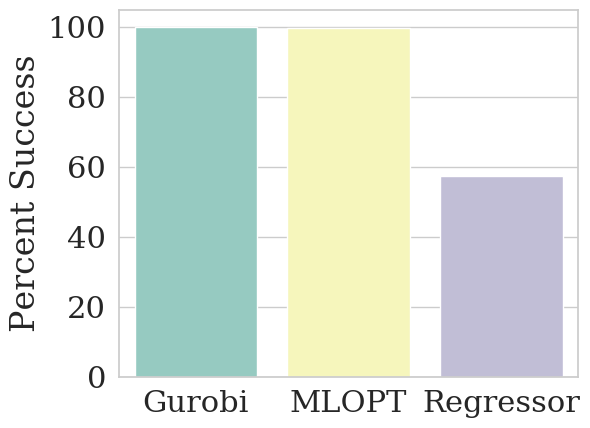

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[9]:4
└ @ Core In[9]:4
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[9]:4
└ @ Core In[9]:4


In [9]:
QP_results = DataFrame()
QP_results.Policy = [ "Gurobi","MLOPT","Regressor"]
QP_results.Success = [mip_percentage, classifier_percentage, regressor_percentage]

ax1 = sns.barplot(x=QP_results[:Policy], y=QP_results[:Success], palette="Set3")
ax1.set(xlabel="", ylabel="Percent Success")
# PyPlot.gcf().subplots_adjust(left=0.15)
PyPlot.tight_layout()

figure = ax1.get_figure();
figure.savefig(string("plots/",system,"_percent_success.pdf"))

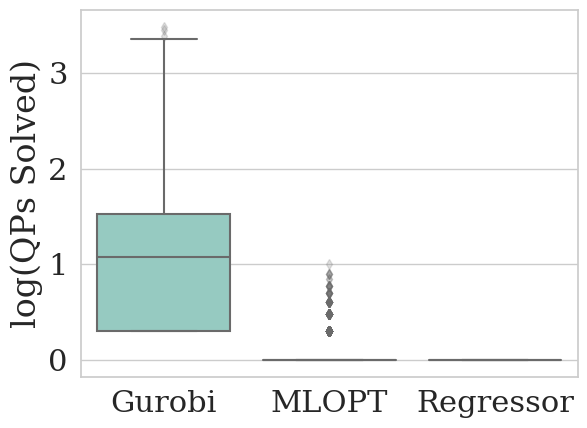

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[11]:8
└ @ Core In[11]:8
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[11]:8
└ @ Core In[11]:8


In [11]:
QP_results = DataFrame()
QP_results.Policy = vcat(fill("Gurobi", length(num_solves_IP)),
                        fill("MLOPT", length(num_solves_classifier)),
                        fill("Regressor", length(num_solves_regressor)))
QP_results.Solves = vcat(log10.(num_solves_IP.+1), log10.(num_solves_classifier), log10.(num_solves_regressor))

flierprops = Dict("alpha"=>0.2)
ax2 = sns.boxplot(x=QP_results[:Policy], y=QP_results[:Solves], palette="Set3", flierprops=flierprops)
ax2.set(xlabel="", ylabel="log(QPs Solved)")
# PyPlot.gcf().subplots_adjust(left=0.15)
PyPlot.tight_layout()

figure = ax2.get_figure()
figure.savefig(string("plots/",system,"_solved.pdf"));

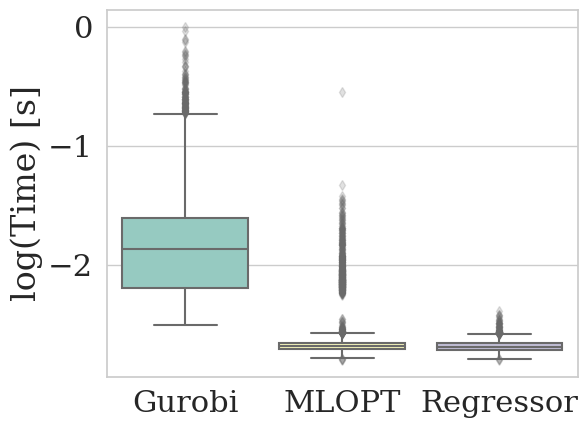

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[12]:8
└ @ Core In[12]:8
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[12]:8
└ @ Core In[12]:8


In [12]:
QP_results = DataFrame()
QP_results.Policy = vcat(fill("Gurobi", length(solve_times_IP)),
                        fill("MLOPT", length(solve_times_classifier)),
                        fill("Regressor", length(solve_times_regressor)))
QP_results.Time = vcat(log10.(solve_times_IP), log10.(solve_times_classifier), log10.(solve_times_regressor))

flierprops = Dict("alpha"=>0.2)
ax3 = sns.boxplot(x=QP_results[:Policy], y=QP_results[:Time], palette="Set3", flierprops=flierprops)
ax3.set(xlabel="", ylabel="log(Time) [s]")
# PyPlot.gcf().subplots_adjust(left=0.15)
PyPlot.tight_layout()

figure = ax3.get_figure()
figure.savefig(string("plots/",system,"_time.pdf"));

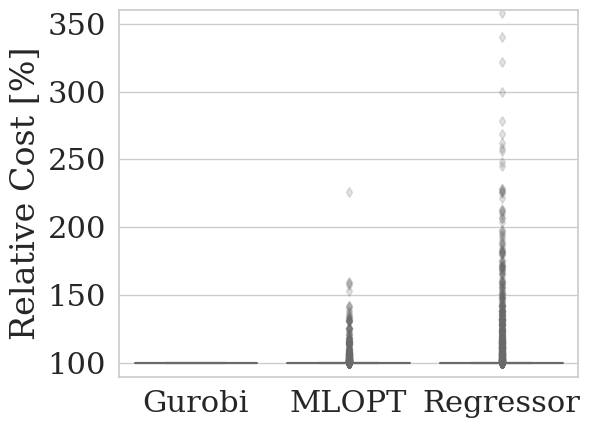

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[13]:8
└ @ Core In[13]:8
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[13]:8
└ @ Core In[13]:8


In [13]:
QP_results = DataFrame()
QP_results.Policy = vcat("Gurobi",
                        fill("MLOPT", length(costs_ratios_classifier)),
                        fill("Regressor", length(costs_ratios_regressor)))
QP_results.Costs = 100 .* [1; costs_ratios_classifier; costs_ratios_regressor]

flierprops = Dict("alpha"=>0.2)
ax4 = sns.boxplot(x=QP_results[:Policy], y=QP_results[:Costs], palette="Set3", flierprops=flierprops)
ax4.set(xlabel="", ylabel="Relative Cost [%]", ylim=(90,360))
# PyPlot.gcf().subplots_adjust(left=0.15)
PyPlot.tight_layout()

figure = ax4.get_figure()
figure.savefig(string("plots/",system,"_cost.pdf"));